In [1]:
# VAE real data gas latent space 02 real data

# VAE for non-supervised intrusion detection

Normal Data : Real Data <br>
Attack Data : Real Data <br>
1000 epochs

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

2022-11-01 10:38:34.242183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 10:38:34.242207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# assign number of components
n_comp = 16

In [4]:
def label_marker(row):
    if isinstance(row[label_name], str) and 'Natural' in row[label_name]:
        return 0
    if isinstance(row[label_name], str) and 'Attack' in row[label_name]:
        return 1
    return 

In [5]:
path_figures = './figures/'

In [6]:
path = './gas/'
path_figures = './figures/'
label_name = 'result'
#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'Normal.csv'
path_attack = path + 'Attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df[label_name] = normal_df.apply(label_marker, axis=1)
attack_df[label_name] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df[label_name].to_numpy() 
attack_label = attack_df[label_name].to_numpy() 

print(len(normal_label))
print(len(attack_label))

61156
35863


In [7]:
# Delete marker column 
normal_df.drop([label_name], axis=1, inplace=True)
attack_df.drop([label_name], axis=1, inplace=True)

In [8]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (61156, 26)
attack shape (35863, 26)


In [9]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

In [10]:
attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [11]:
#labels = combine_labels
#norm_samples = df_scaled[labels == 0]  # normal data
#attack_samples = df_scaled[labels == 1]  # attack data

#norm_labels = labels[labels == 0]
#attack_labels = labels[labels == 1]

In [12]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(35863, 26)
(61156, 26)


In [13]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [14]:
X_train.shape
print(' X_test normal shape',X_test_norm.shape, '\n', 
      'X_test attack shape', X_test_attack.shape, '\n',
      'X_train normal shape', X_train.shape, '\n',
      'X_test shape', X_test.shape)

 X_test normal shape (12232, 26) 
 X_test attack shape (12232, 26) 
 X_train normal shape (48924, 26) 
 X_test shape (24464, 26)


In [15]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [16]:
# The reparameterization trick for the autoencoder

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [17]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2) 
latent_dim = int(original_dim / 3) 

#intermediate_dim = 256
latent_dim = 2
print(' original_dim : ', original_dim,'\n',
      'intermediate_dim : ', intermediate_dim, '\n', 
      'latent_dim : ', latent_dim)

 original_dim :  26 
 intermediate_dim :  13 
 latent_dim :  2


In [18]:
# enconder >< decoder
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 26)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 13)           351         ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 6)            84          ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 2)            14          ['dense_1[0][0]']                
                                                                                            

In [19]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 18        
                                                                 
 dense_3 (Dense)             (None, 13)                91        
                                                                 
 dense_4 (Dense)             (None, 26)                364       
                                                                 
Total params: 473
Trainable params: 473
Non-trainable params: 0
_________________________________________________________________


In [20]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [21]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [22]:
# Training VAE autoencoder
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
es = EarlyStopping(monitor='loss', mode='min', patience=5)
vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=300,
                        batch_size=256,
                        callbacks = [es])

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 26)]              0         
                                                                 
 encoder (Functional)        (None, 2)                 463       
                                                                 
 decoder (Functional)        (None, 26)                473       
                                                                 
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________
Train on 48924 samples
Epoch 1/300


2022-11-01 10:38:37.327929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 10:38:37.328545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 10:38:37.328688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-01 10:38:37.328833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-01 10:38:37.331435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

48924/48924 [==============================] - 1s 11us/sample - loss: 1517.8382
Epoch 2/300
48924/48924 [==============================] - 0s 5us/sample - loss: 1408.4362
Epoch 3/300
48924/48924 [==============================] - 0s 5us/sample - loss: 1257.5022
Epoch 4/300
48924/48924 [==============================] - 0s 5us/sample - loss: 1053.1506
Epoch 5/300
48924/48924 [==============================] - 0s 5us/sample - loss: 806.0730
Epoch 6/300
48924/48924 [==============================] - 0s 5us/sample - loss: 567.2506
Epoch 7/300
48924/48924 [==============================] - 0s 5us/sample - loss: 393.4175
Epoch 8/300
48924/48924 [==============================] - 0s 5us/sample - loss: 298.1496
Epoch 9/300
48924/48924 [==============================] - 0s 5us/sample - loss: 238.0333
Epoch 10/300
48924/48924 [==============================] - 0s 5us/sample - loss: 199.3303
Epoch 11/300
48924/48924 [==============================] - 0s 5us/sample - loss: 180.0331
Epoch 12/300
48

Epoch 92/300
48924/48924 [==============================] - 0s 5us/sample - loss: 12.1546
Epoch 93/300
48924/48924 [==============================] - 0s 5us/sample - loss: 12.1596
Epoch 94/300
48924/48924 [==============================] - 0s 5us/sample - loss: 12.0558
Epoch 95/300
48924/48924 [==============================] - 0s 5us/sample - loss: 12.0294
Epoch 96/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.9877
Epoch 97/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.9505
Epoch 98/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.9129
Epoch 99/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.8653
Epoch 100/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.8702
Epoch 101/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.8384
Epoch 102/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.7923
Epoch 1

48924/48924 [==============================] - 0s 5us/sample - loss: 11.0120
Epoch 183/300
48924/48924 [==============================] - 0s 5us/sample - loss: 10.9964
Epoch 184/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.0189
Epoch 185/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.0016
Epoch 186/300
48924/48924 [==============================] - 0s 5us/sample - loss: 10.9974
Epoch 187/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.0115
Epoch 188/300
48924/48924 [==============================] - 0s 5us/sample - loss: 11.0036


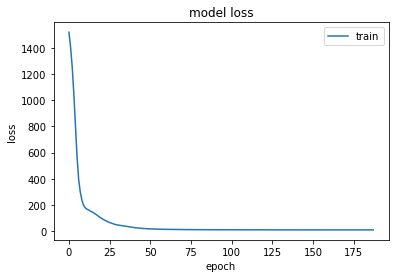

In [23]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [24]:
# Prediction of training vector
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.99)
print('error threshold >>>', error_thresh)

Avg error 0.0028847472582711085
median error       0.0016741279275156729
99Q: 0.04085465408059864
error threshold >>> 0.04085465408059864


In [26]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  24464
Number of anomalies :  12449
total length of y_test vector 24464
total lenght of attacks in y_test vector 12232


In [27]:
# Sklearn classification report
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12232
         1.0       0.98      1.00      0.99     12232

    accuracy                           0.99     24464
   macro avg       0.99      0.99      0.99     24464
weighted avg       0.99      0.99      0.99     24464



In [28]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [29]:
# PCA transformation to observe variance in 2 components


#, svd_solver='arpack'
pca = PCA(n_components=2, random_state=123)
X_transform = pca.fit_transform(X_pred2)

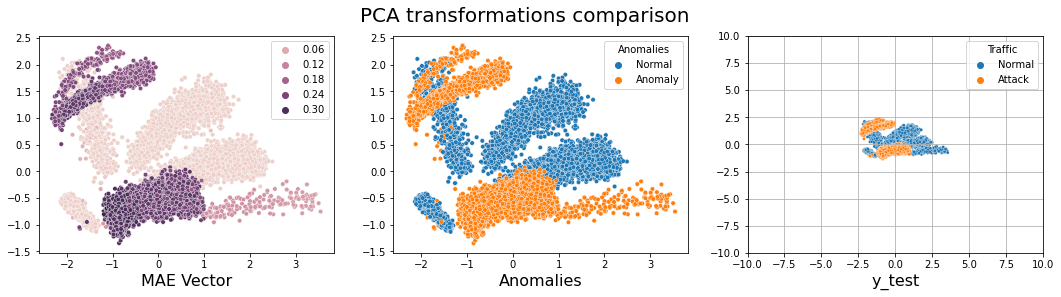

In [30]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.grid()
plt.show()

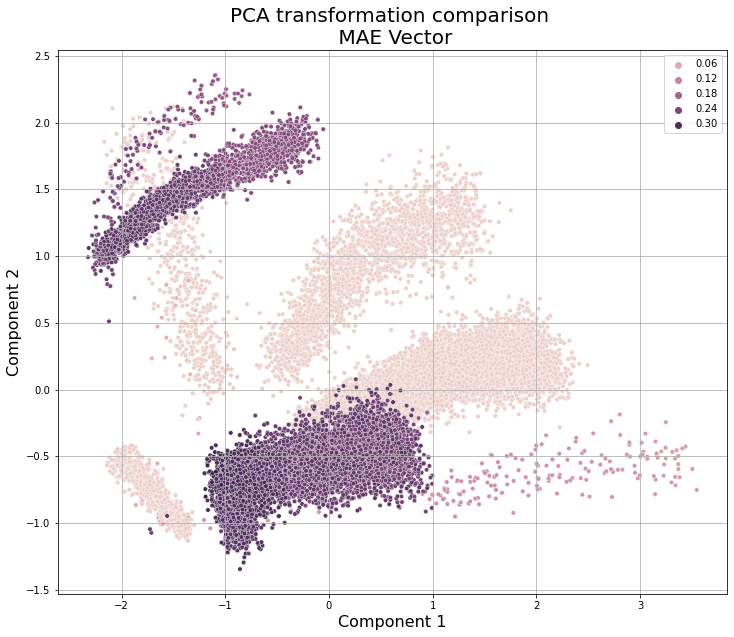

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n MAE Vector',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

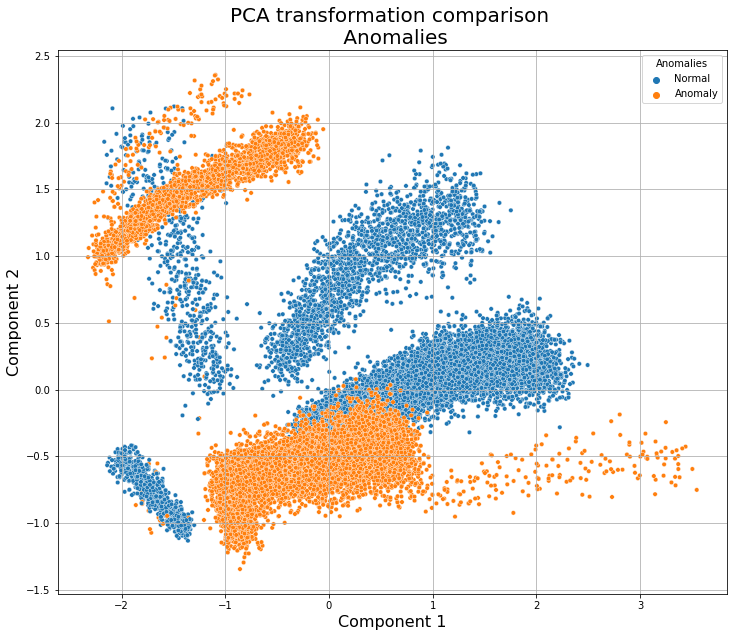

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Anomalies',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Anomaly'], title='Anomalies')
plt.grid()
plt.show()

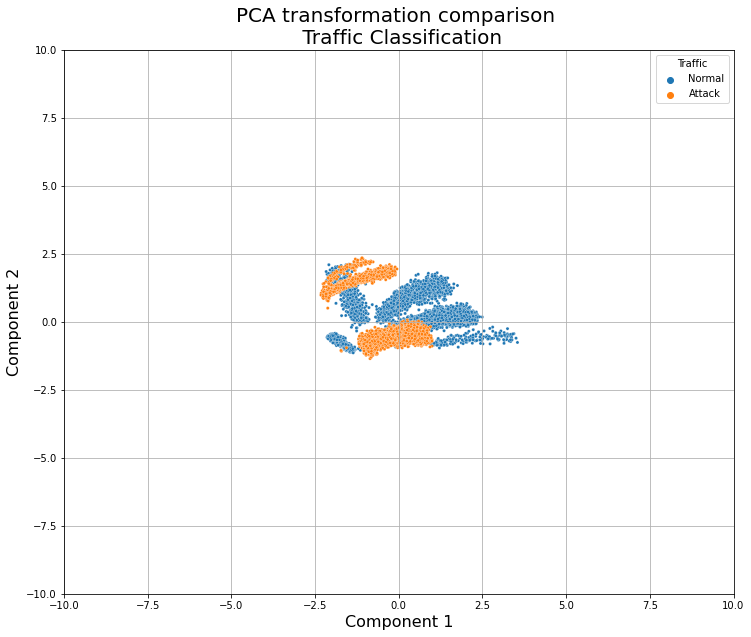

In [33]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.grid()
plt.show()

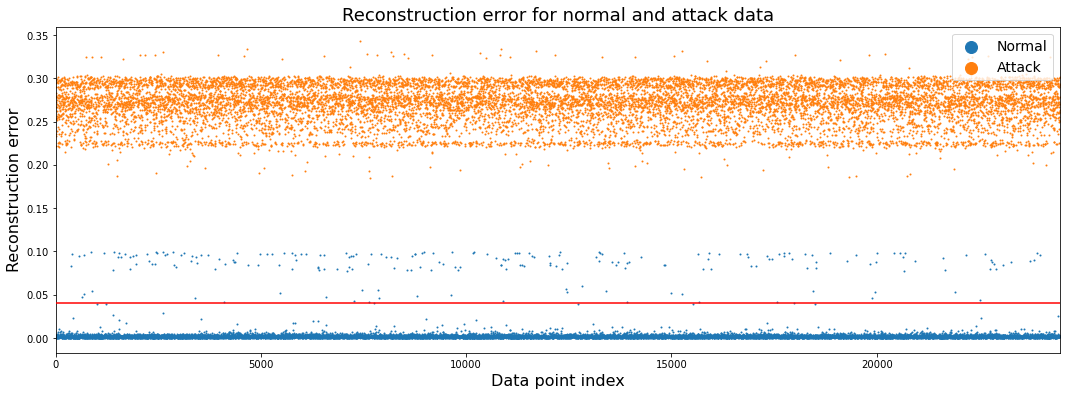

In [34]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [35]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (12232,) 
 Normal_error shape (12232,)


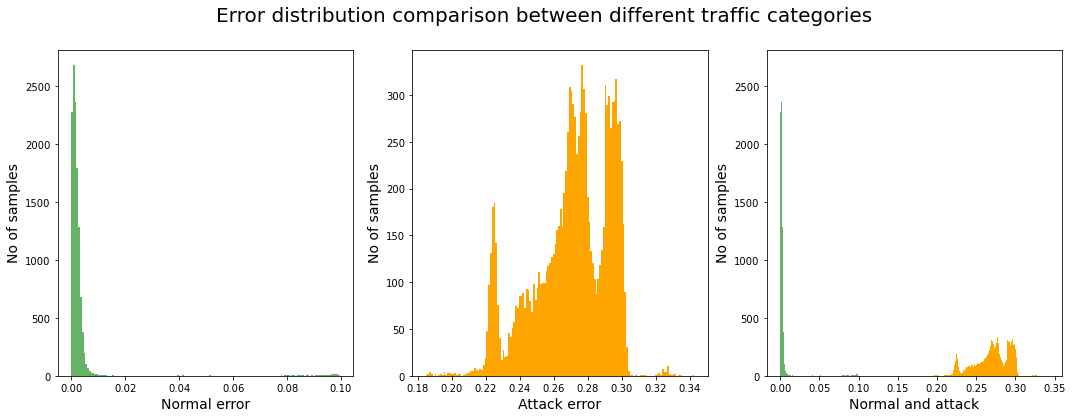

In [36]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

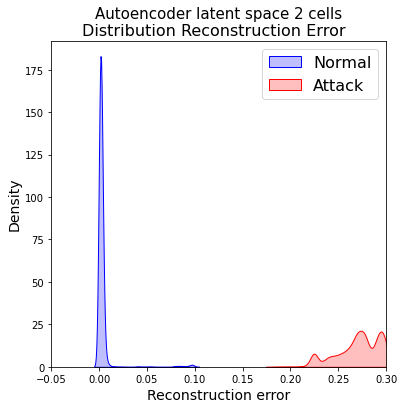

In [37]:
# === Paper Figure ===
# Distribución reconstruction error 
latent_space = latent_dim
plt.rcParams['axes.titley'] = 1.05

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(
    Normal_error,
    fill    = True,
    ax      = ax,
    label   = 'Normal',
    color   = 'blue'
)
sns.kdeplot(
    Attack_error,
    fill    = True,
    ax      = ax,
    label   = 'Attack',
    color   = 'red'
)
#sns.rugplot(error_reconstruccion,  ax=ax, color='black')
plt.suptitle('Distribution Reconstruction Error',y=0.92, 
            fontsize=16)
ax.set_title('Autoencoder latent space '+str(latent_space)+' cells', fontsize=15)
ax.set_xlabel('Reconstruction error', fontsize = 14);
ax.set_ylabel('Density',fontsize=14);
ax.set_xlim(-0.05,0.3)
plt.legend( fontsize=16)
plt.savefig(path_figures+'VAE_'+str(latent_space)+'_rea_gas.png', dpi=600)
plt.show()

In [38]:
X_pred2.shape

(24464, 2)

In [39]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=231)
tsne_results = tsne.fit_transform(X_pred2)

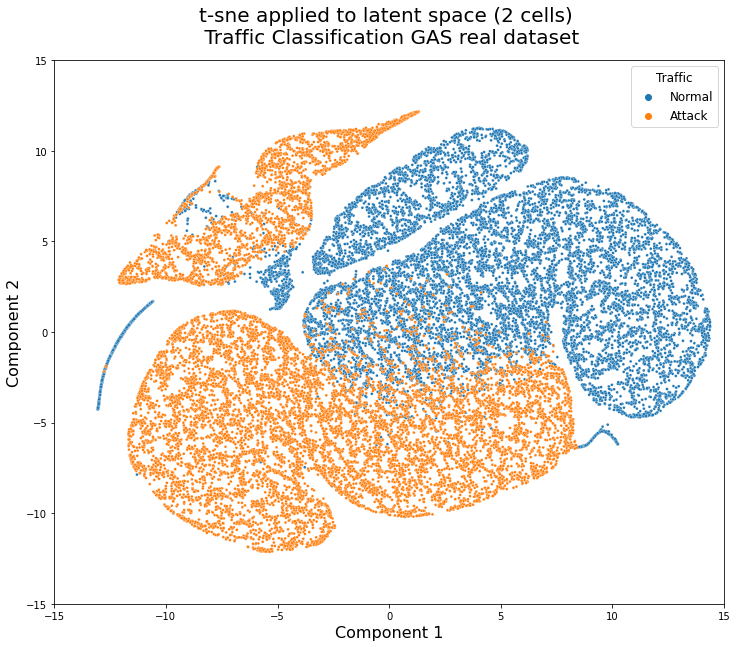

In [42]:
# Analisis latent space with t-SNE

plt.rcParams['axes.titley'] = 1.02


df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two']) 

fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('t-sne applied to latent space (2 cells) \n Traffic Classification GAS real dataset',size=20)
ax.set_ylabel('Component 2', size=16)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    alpha=1,
    data=df_subset,
    cmap=custom_cmap,
    s = 8
)
ax.set_xlabel('Component 1', size=16)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic', fontsize=12, title_fontsize=12)
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
plt.savefig(path_figures+'TSNE_'+str(latent_space)+'_rea_gas.png', dpi=600)
plt.show()

In [41]:
# does not apply for 2d latent space
stop

NameError: name 'stop' is not defined

In [ ]:
# t-sne transformation to observe variance in 3 components of latent space

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=123)
tsne_results = tsne.fit_transform(X_pred2)
plt.rcParams['axes.titlepad'] = -14 
df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two', 'tsne-2d-three']) 

In [ ]:
# t-sne figure 3D

plt.rcParams['axes.titley'] = .95

fig = plt.figure(figsize=(8,8))
ax= Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.axes.set_xlim3d(left=-4, right=6)
ax.axes.set_ylim3d(bottom=-4, top=6)
ax.axes.set_zlim3d(bottom=-3, top=3)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sc = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
               c=y_test, alpha = 1, cmap=custom_cmap, s=2)
plt.title('3D t-sne applied to latent space \n Traffic Classification',size=20)

ax.set_xlabel('Component 1', size=16)
ax.set_ylabel('Component 2', size=16)
ax.set_zlabel('Component 3', size=16)
# rotate the axes and update
#fig.tight_layout()
fig.subplots_adjust(left=0, right=1, bottom=-10, top=-2)
ax.view_init(10, 60)
plt.show()

In [ ]:
#EOF